In [2]:
#Import primary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import pulp as pl # is a Python linear programming API for defining problems and invoking external solvers.
from tabulate import tabulate
import operator
import attr
from pulp import *
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable
from pulp import GLPK
import os
import plotly.figure_factory as ff

#!pip install plotly_express
#!pip install chart_studio
#!pip install cufflinks
#import chart_studio.plotly as py
#from plotly.offline import init_notebook_mode, iplot
#init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import matplotlib.pyplot as plt # matplotlib
#import os
#import plotly.figure_factory as ff
#import cufflinks as cf
#cf.set_config_file(offline=False, world_readable=True, theme='pearl')

In [16]:
#import file
mcd = pd.read_csv("menu.csv")
mcd
#print(mcd)

,Category,Item,Serving Size,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,...,Carbohydrates,Carbohydrates (% Daily Value),Dietary Fiber,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,120,13.0,20,5.0,25,0.0,...,31,10,4,17,3,17,10,0,25,15
1,Breakfast,Egg White Delight,4.8 oz (135 g),250,70,8.0,12,3.0,15,0.0,...,30,10,4,17,3,18,6,0,25,8
2,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,200,23.0,35,8.0,42,0.0,...,29,10,4,17,2,14,8,0,25,10
3,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,250,28.0,43,10.0,52,0.0,...,30,10,4,17,2,21,15,0,30,15
4,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,210,23.0,35,8.0,42,0.0,...,30,10,4,17,2,21,6,0,25,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,Smoothies & Shakes,McFlurry with Oreo Cookies (Small),10.1 oz (285 g),510,150,17.0,26,9.0,44,0.5,...,80,27,1,4,64,12,15,0,40,8
256,Smoothies & Shakes,McFlurry with Oreo Cookies (Medium),13.4 oz (381 g),690,200,23.0,35,12.0,58,1.0,...,106,35,1,5,85,15,20,0,50,10
257,Smoothies & Shakes,McFlurry with Oreo Cookies (Snack),6.7 oz (190 g),340,100,11.0,17,6.0,29,0.0,...,53,18,1,2,43,8,10,0,25,6
258,Smoothies & Shakes,McFlurry with Reese's Peanut Butter Cups (Medium),14.2 oz (403 g),810,290,32.0,50,15.0,76,1.0,...,114,38,2,9,103,21,20,0,60,6


In [4]:
# Clean the data:
mcd.loc[mcd['Item'].str.contains('Dr'),'Protein']=0
mcd = mcd[~(mcd['Calories'] == 1880)]

1. How many calories does the average McDonald's value meal contain?

In [150]:
mcd.groupby(['Category'])['Calories'].mean()

Category
Beef & Pork           494.000000
Beverages             113.703704
Breakfast             526.666667
Chicken & Fish        501.923077
Coffee & Tea          283.894737
Desserts              222.142857
Salads                270.000000
Smoothies & Shakes    531.428571
Snacks & Sides        245.769231
Name: Calories, dtype: float64

All menus' average calorie

In [115]:
mcd['Calories'].mean()

362.43243243243245

2. How much do beverages, like soda or coffee, contribute to the overall caloric intake?

In [116]:
# group calories by categories and apply sum() function 
pie_mcd = mcd.groupby('Category', axis=0).sum()
print(type(pie_mcd))

<class 'pandas.core.frame.DataFrame'>


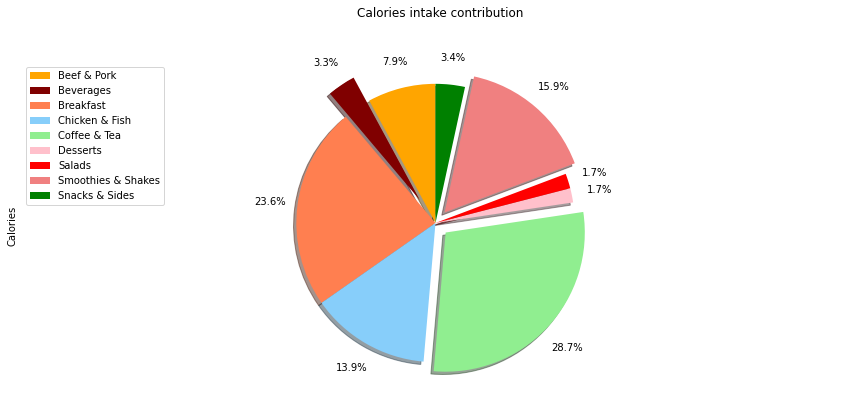

In [117]:
colors_list = ['orange', 'maroon', 'coral', 'lightskyblue', 'lightgreen', 'pink', 'red', 'lightcoral', 'green']
explode_list = [0, 0.2, 0, 0, 0.1, 0, 0, 0.1, 0] # ratio for each category with which to offset each wedge.

pie_mcd['Calories'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.2,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 Categories
                            )

# scale the title up by 12% to match pctdistance
plt.title('Calories intake contribution', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=pie_mcd.index, loc='upper left') 

plt.show()

3. Does ordered grilled chicken instead of crispy increase a sandwich's nutritional value?

5. What is the least number of items could you order from the menu to meet one day's nutritional requirements?

In [5]:
# Convert the item names to a list
menu_mcd = mcd.Item.tolist()
# Convert all of the macro nutrients fields to be dictionaries of the item names
Calories = mcd.set_index('Item')['Calories'].to_dict()
TotalFat = mcd.set_index('Item')['Total Fat'].to_dict()
SaturatedFat = mcd.set_index('Item')['Saturated Fat'].to_dict()
Carbohydrates = mcd.set_index('Item')['Carbohydrates'].to_dict()
Sugars = mcd.set_index('Item')['Sugars'].to_dict()
Protein = mcd.set_index('Item')['Protein'].to_dict()
Sodium = mcd.set_index('Item')['Sodium'].to_dict()

In [6]:
#minimization problem
prob=LpProblem("McOptimizationProblem",LpMinimize)

In [7]:
#set the minimum amount
variasi_menu = LpVariable.dicts("MenuItems",menu_mcd,lowBound=0,upBound=10,cat='Integer')

In [8]:
#Constraints
# First entry is the calorie calculation
prob += lpSum([Calories[i]*variasi_menu[i] for i in menu_mcd]), 'Calories'
# Total Fat must be <= 70 g
prob += lpSum([TotalFat[i]*variasi_menu[i] for i in menu_mcd]) <=70, 'Total_Fat'
# Saturated Fat is <= 20 g
prob += lpSum([SaturatedFat[i]*variasi_menu[i] for i in menu_mcd]) <= 20, 'Saturated_Fat'
# Carbohydrates must be more than 260 g
prob += lpSum([Carbohydrates[i]*variasi_menu[i] for i in menu_mcd]) >= 260, 'Carbohydrates_lower'
# Sugar between 80-100 g
prob += lpSum([Sugars[i]*variasi_menu[i] for i in menu_mcd]) >= 80, 'Sugars_lower'
prob += lpSum([Sugars[i]*variasi_menu[i] for i in menu_mcd]) <= 100, 'Sugars_upper'
# Protein between 45-55g
prob += lpSum([Protein[i]*variasi_menu[i] for i in menu_mcd]) >= 45, 'Protein_lower'
prob += lpSum([Protein[i]*variasi_menu[i] for i in menu_mcd]) <= 55, 'Protein_upper'
# Sodium <= 6000 mg
prob += lpSum([Sodium[i]*variasi_menu[i] for i in menu_mcd]) <= 6000, 'Sodium'

In [9]:
#del prob.constraints

In [15]:
prob.writeLP("McOptimization.lp")
prob.solve()
data_matrix = []
data_matrix.append(['Item', 'Amount','Calories','Total Fat','Carbohydrates','Protein','Sodium'])

print("Status:", LpStatus[prob.status])
for v in prob.variables():
    if v.varValue > 0:
        Item = mcd.loc[mcd['Item'] == v.name.replace('MenuItems_','').replace('_',' ')]
        Item_Calories = Item['Calories'].values*v.varValue
        Item_TotalFat = Item['Total Fat'].values*v.varValue
        Item_Carbohydrates = Item['Carbohydrates'].values*v.varValue
        Item_Protein = Item['Protein'].values*v.varValue
        Item_Sodium = Item['Sodium'].values*v.varValue


        data_matrix.append([v.name.replace('MenuItems_','').replace('_',' '),v.varValue,Item_Calories[0], \
                           Item_TotalFat[0],Item_Carbohydrates[0],Item_Protein[0],Item_Sodium[0]])


print(' ')
results = {}
print("Total Calories = ", value(prob.objective))
for constraint in prob.constraints:
    s = 0
    for var, coefficient in prob.constraints[constraint].items():
        sum += var.varValue * coefficient
    results[prob.constraints[constraint].name.replace('_lower','').replace('_upper','')] = s  

table = ff.create_table(data_matrix)
print(data_matrix)
iplot(table, filename='simple_table')
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Nutrition',
    x=["TotalFat","Saturated Fat","Carbohydrates","Sugars","Protein","Sodium"], \
    y=[y_data["TotalFat"],y_data["Saturated_Fat"],y_data["Carbohydrates"],y_data["Sugars"],y_data["Protein"],y_data["Sodium"]/1000],
    error_y=dict(
            type='data',
            symmetric=False,
            array=[70-y_data["TotalFat"], 20-y_data["Saturated_Fat"], 0, 100-y_data["Sugars"],55-y_data["Protein"],2-y_data["Sodium"]/1000],
            arrayminus=[y_data["TotalFat"]-0,y_data["Saturated_Fat"]-0,y_data["Carbohydrates"]-260,y_data["Sugars"]-80,y_data["Protein"]-45,y_data["Sodium"]/1000-0])
))

fig.layout.update(barmode='group')
iplot(fig, filename='r')

PulpSolverError: PuLP: Error while executing glpsol.exe